<h2>Import packages and install histomics_detect</h2>

In [5]:
import sys
import tensorflow as tf

#install histomics_detect
!pip install -e /tf/notebooks/histomics_detect

#add to system path
sys.path.append('/tf/notebooks/histomics_detect/')

Obtaining file:///tf/notebooks/histomics_detect
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 36.7 MB/s eta 0:00:01
  Running setup.py develop for histomics-detect
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


<h2>Define dataset parameters and create datasets</h2>

In [6]:
#import dataset related packages
from histomics_detect.io import roi_tensors
from histomics_detect.io import read_roi
from histomics_detect.augmentation import crop
from histomics_detect.augmentation import flip
import numpy as np
import os
from PIL import Image

#input data path
path = './data/'

#training parameters
train_tile = 224 #input image size
min_area_thresh = 0.5 # % of object area that must be in crop to be included

#build (.png, image size, slide, .csv) file tuples
files = os.listdir(path)
pngs = [path + f for f in files if f.split('.')[-1] == 'png']
files = [(png, Image.open(png).size, png.split('.')[3],
          '.'.join(png.split('.')[0:-1]) + '.csv') for png in pngs]

#filter on png size
files = [(png, size, slide, csv) for (png, size, slide, csv) in files
         if (size[0] > train_tile) and (size[1] > train_tile)]

#randomly assign 20% of slides to validation
slides = list(set([file[2] for file in files]))

id = np.random.randint(0, len(slides)-1, size=(np.ceil(0.2*len(slides)).astype(np.int32)))
validation = [slide for (i, slide) in enumerate(slides) if i in id]
training = list(set(slides).difference(validation))
training_files = [(png, csv) for (png, size, slide, csv) in files if slide in training]
validation_files = [(png, csv) for (png, size, slide, csv) in files if slide in validation]

#convert to tensors
training_rois = roi_tensors(training_files)
validation_rois = roi_tensors(validation_files)

#arguments
width = tf.constant(train_tile, tf.int32)
height = tf.constant(train_tile, tf.int32)
min_area = tf.constant(min_area_thresh, tf.float32)

#build training dataset
ds_train_roi = tf.data.Dataset.from_tensor_slices(training_rois)
ds_train_roi = ds_train_roi.map(lambda x: read_roi(x))
ds_train_roi = ds_train_roi.map(lambda x, y: detection_crop(x, y, width, height,
                                                            min_area_thresh))
ds_train_roi = ds_train_roi.map(lambda x, y: detection_flip(x, y))
ds_train_roi = ds_train_roi.prefetch(tf.data.experimental.AUTOTUNE)

#build validation datasets
ds_validation_roi = tf.data.Dataset.from_tensor_slices(validation_rois)
ds_validation_roi = ds_validation_roi.map(lambda x: read_roi(x))
ds_validation_roi = ds_validation_roi.prefetch(tf.data.experimental.AUTOTUNE)

<h2>Create and train detection model</h2>

In [7]:
#import network generation and training packages
from histomics_detect.networks.rpns import rpn
from histomics_detect.models.faster_rcnn import FasterRCNN
from histomics_detect.models.faster_rcnn import CustomCallback

#choices for anchor sizes - all anchors 1:1 aspect ratio
anchor_px = tf.constant([32, 64, 96], dtype=tf.int32) #width/height of square anchors in pixels at input mag.

#feature network parameters
backbone_stride = 1 #strides in feature generation network convolution
backbone_blocks = 14
backbone_dimension = 256 #number of features generated by rpn convolution

#rpn network parameters
rpn_kernel = [3] #kernel size for rpn convolution
rpn_act_conv = ['relu'] #activation for rpn convolutional layers

#anchor filtering parameters
neg_max = 128 #maximum number of negative/positive anchors to keep in each roi
pos_max = 128
rpn_lmbda = 10.0 #weighting for rpn regression loss
roialign_tiles = 3.0 #roialign - number of horizontal/vertical tiles in a proposal
roialing_pool = 2.0 #roialign - number of horizontal/vertical samples in each tile

#create backbone and rpn networks
resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(train_tile, train_tile, 3), pooling=None)
rpnetwork, backbone = rpn(resnet50, n_anchors=tf.size(anchor_px),
                          stride=backbone_stride, blocks=backbone_blocks, 
                          kernels=rpn_kernel, dimensions=[backbone_dimension],
                          activations=rpn_act_conv)

#create FasterRCNN keras model
model = FasterRCNN(rpnetwork, backbone, [width, height], anchor_px, rpn_lmbda)

#compile FasterRCNN model with losses
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    tf.keras.losses.Huber()])

#fit FasterRCNN model
model.fit(x=ds_train_roi, batch_size=1, epochs=50, verbose=1, callbacks=[CustomCallback()])

94773248/94765736 [==============================] - 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/interpolate_bilinear/gather-bottom_right/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/interpolate_bilinear/gather-bottom_right/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradients/interpolate_bilinear/gather-bottom_right/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/interpolate_bilinear/gather-bottom_left/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/interpolate_bilinear/gather-bottom_left

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/loop_body/GatherV2/pfor/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_12:0", shape=(None,), dtype=int32), values=Tensor("concat_11:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
 

85/85 [==============================] - 21s 60ms/step - rpn_objectness: 0.7103 - rpn_regression: 0.3223 - align_regression: 2.1272 - mean_iou_rpn: 0.4509 - mean_iou_align: -inf - auc_roc: 0.5773 - pr_roc: 0.4044 - true_positives: 204.0000 - false_negatives: 609.0000 - false_positives: 241.0000
Epoch 2/50
85/85 [==============================] - 5s 59ms/step - rpn_objectness: 0.7193 - rpn_regression: 0.0384 - align_regression: 0.0523 - mean_iou_rpn: 0.6565 - mean_iou_align: 0.6162 - auc_roc: 0.5838 - pr_roc: 0.3794 - true_positives: 97.0000 - false_negatives: 776.0000 - false_positives: 152.0000
Epoch 3/50
85/85 [==============================] - 5s 60ms/step - rpn_objectness: 0.7086 - rpn_regression: 0.0283 - align_regression: 0.0305 - mean_iou_rpn: 0.7026 - mean_iou_align: 0.6910 - auc_roc: 0.6073 - pr_roc: 0.3973 - true_positives: 33.0000 - false_negatives: 779.0000 - false_positives: 43.0000
Epoch 4/50
85/85 [==============================] - 5s 58ms/step - rpn_objectness: 0.6981 -

rpn precision:  0.94736842105263153
rpn recall:  0.94736842105263153
rpn tp:  18
rpn fp:  1
rpn fn:  1
roialign precision:  0.94736842105263153
roialign recall:  0.94736842105263153
roialign tp:  18
roialign fp:  1
roialign fn:  1


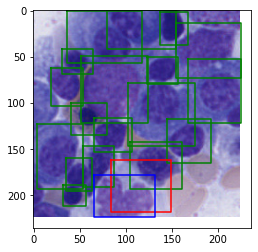

In [8]:
#demonstrates nms and display of test sample results
from histomics_detect.anchors import create_anchors
from histomics_detect.boxes.transforms import unparameterize, clip_boxes, tf_box_transform
from histomics_detect.metrics.iou import greedy_iou, iou
from histomics_detect.models.faster_rcnn import map_outputs
from histomics_detect.roialign.roialign import roialign
from histomics_detect.visualization import plot_inference


#generate sample from validation dataset
output = list(ds_validation_roi.shuffle(100).as_numpy_iterator())[0]
rgb = output[0]
boxes = output[1]

#parameters for nms
nms_iou = 0.3
map_iou = 0.5
delta = 0.1

#normalize image
norm = tf.keras.applications.resnet.preprocess_input(tf.cast(rgb, tf.float32))

#expand dimensions
norm = tf.expand_dims(norm, axis=0)
        
#predict and capture intermediate features
features = model.backbone(norm, training=True)
output = model.rpnetwork(features, training=True)

#generate anchors
anchors = create_anchors(anchor_px, model.field, tf.shape(rgb)[1], tf.shape(rgb)[0])

#transform outputs to 2D arrays with anchors in rows
rpn_obj = tf.nn.softmax(map_outputs(output[0], anchors,
                                    model.anchor_px, model.field))
rpn_reg = map_outputs(output[1], anchors, model.anchor_px, model.field)        
rpn_boxes = unparameterize(rpn_reg, anchors)
        
#clip regressed boxes to border, transform, and do nonmax supression
rpn_boxes = clip_boxes(rpn_boxes, tf.shape(rgb)[1], tf.shape(rgb)[0])
selected = tf.image.non_max_suppression(tf_box_transform(rpn_boxes),
                                        rpn_obj[:,1], tf.shape(rpn_obj)[0],
                                        iou_threshold=nms_iou)
rpn_boxes = tf.gather(rpn_boxes, selected, axis=0)
rpn_obj = tf.gather(rpn_obj, selected, axis=0)

#select objects predicted by region proposal network
positive = tf.greater(rpn_obj[:,1], 0.5)
rpn_boxes_positive = tf.boolean_mask(rpn_boxes, positive, axis=0)
rpn_obj_positive = tf.boolean_mask(rpn_obj, positive, axis=0)
        
#generate roialign predictions for rpn positive predictions
interpolated = roialign(features, rpn_boxes_positive, model.field, pool=2, tiles=3)
align_reg = model.fastrcnn(interpolated)
align_boxes = unparameterize(align_reg, rpn_boxes_positive)
        
#rpn accuracy measures via greedy iou mapping
rpn_ious, _ = iou(rpn_boxes_positive, boxes)
precision, recall, tp, fp, fn, tp_list, fp_list, fn_list = greedy_iou(rpn_ious, map_iou)
tf.print('rpn precision: ', precision)
tf.print('rpn recall: ', recall)
tf.print('rpn tp: ', tp)
tf.print('rpn fp: ', fp)
tf.print('rpn fn: ', fn)
        
#roialign accuracy measures via greedy iou mapping
rpn_ious, _ = iou(align_boxes, boxes)
precision, recall, tp, fp, fn, tp_list, fp_list, fn_list = greedy_iou(rpn_ious, map_iou)
tf.print('roialign precision: ', precision)
tf.print('roialign recall: ', recall)
tf.print('roialign tp: ', tp)
tf.print('roialign fp: ', fp)
tf.print('roialign fn: ', fn)

#plot figure
plot_inference(rgb, boxes, align_boxes, tp_list[:,0], fp_list, fn_list)

<h2>Save and Load Model Weights</h2>

In [ ]:
weight_path = "cpk"
model.save_weights(weight_path)
model_reload = FasterRCNN(rpnetwork, backbone, [width, height], anchor_px, rpn_lmbda)
model_reload.load_weights(weight_path)

align_reg = model.fastrcnn(interpolated)
align_reg_reload = model_reload.fastrcnn(interpolated)

assert tf.reduce_sum(tf.cast(align_reg_reload == align_reg, tf.int32)) == tf.math.reduce_prod(tf.shape(align_reg))